# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
import os 
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

In [2]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
lsa_reports = "../../../reports/lsa/"

graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

In [4]:
def load_sparse_dataframe(matrix_path,row_path,column_path,cols_str=True):
    mat = sparse.load_npz(matrix_path)
    row = np.loadtxt(row_path)
    if cols_str:
        col = np.loadtxt(column_path, dtype="str")
    else:
        col = np.loadtxt(column_path)
        
    df = pd.DataFrame.sparse.from_spmatrix(mat, index=row, columns=col)
    return df

# Cargo archivos

In [65]:
#Analisis previos
infomap_clusters = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_clusters = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [5]:
# Document-Term-Matrix  de clusters

path_infomap = data_processed + "tfidf_infomap/"
path_louvain = data_processed + "tfidf_louvain/"

monograms_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_0.npz",path_infomap + "rows_tfidf_infomap_0.txt", path_infomap+"cols_tfidf_infomap_0.txt")
monograms_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_0.npz",path_louvain + "rows_tfidf_louvain_0.txt", path_louvain+"cols_tfidf_louvain_0.txt")

bigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_1.npz",path_infomap + "rows_tfidf_infomap_1.txt", path_infomap+"cols_tfidf_infomap_1.txt")
bigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_1.npz",path_louvain + "rows_tfidf_louvain_1.txt", path_louvain+"cols_tfidf_louvain_1.txt")

trigrams_infomap = load_sparse_dataframe(path_infomap + "matriz_tfidf_infomap_2.npz",path_infomap + "rows_tfidf_infomap_2.txt", path_infomap+"cols_tfidf_infomap_2.txt")
trigrams_louvain = load_sparse_dataframe(path_louvain + "matriz_tfidf_louvain_2.npz",path_louvain + "rows_tfidf_louvain_2.txt", path_louvain+"cols_tfidf_louvain_2.txt")

infomap_dtm = [monograms_infomap, bigrams_infomap, trigrams_infomap]
louvain_dtm = [monograms_louvain, bigrams_louvain, trigrams_louvain]

In [6]:
# Document-Term-Matrix de nodos
path = data_processed + "tfidf_nodos/"
monograms_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_0.npz",path+"rows_tfidf_nodos_0.txt",path+"cols_tfidf_nodos_0.txt")
bigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_1.npz",path+"rows_tfidf_nodos_1.txt",path+"cols_tfidf_nodos_1.txt")
trigrams_dtm = load_sparse_dataframe(path+"matriz_nodos_tfidf_2.npz",path+"rows_tfidf_nodos_2.txt",path+"cols_tfidf_nodos_2.txt")

document_term_matrix = [monograms_dtm, bigrams_dtm, trigrams_dtm]

In [7]:
n_components=250

# Scree plot

### Nodos

In [10]:
X_nodos = monograms_dtm.sparse.to_dense()

svd = TruncatedSVD(n_components=n_components, random_state=seed)
lsa = svd.fit(X_nodos)

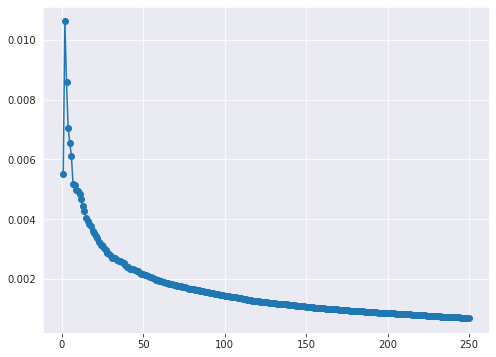

In [11]:
y = lsa.explained_variance_ratio_
x = np.linspace(1,len(y),len(y))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x,y,"o-")

In [14]:
print(f"Con {n_components} componentes tengo {round(lsa.explained_variance_ratio_.sum()*100,2)}% de varianza explicada")

Con 250 componentes tengo 41.96% de varianza explicada


Para elegir un porcentaje de varianza y sacar el corte

In [ ]:
# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=2000)
# ax.set_ylabel('Fracción de varianza acumulada - Nodos')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 80% de varianza acumlada con {corte} componentes")
# # fig.savefig(lsa_reports+"evr_plot.png")

### Clusters

In [19]:
n_components_infomap = 250
n_components_louvain = 100


X_infomap = infomap_dtm[0].sparse.to_dense()

svd_infomap = TruncatedSVD(n_components=n_components_infomap,random_state=seed)
lsa_infomap = svd_infomap.fit(X_infomap)

X_louvain = louvain_dtm[0].sparse.to_dense()

svd_louvain = TruncatedSVD(n_components=n_components_louvain, random_state=seed)
lsa_louvain = svd_louvain.fit(X_louvain)

print(f"Infomap: Con {n_components_infomap} componentes tengo {round(lsa_infomap.explained_variance_ratio_.sum()*100,2)}% de varianza explicada \n")
print(f"Louvain: Con {n_components_louvain} componentes tengo {round(lsa_louvain.explained_variance_ratio_.sum()*100,2)}% de varianza explicada \n")

Infomap: Con 250 componentes tengo 60.21% de varianza explicada 

Louvain: Con 100 componentes tengo 61.34% de varianza explicada 



Para elegir un porcentaje de varianza y sacar el corte

In [ ]:
# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa_infomap.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=1000)
# ax.set_ylabel('Fracción de varianza acumulada - Clusters Infomap')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")
# # fig.savefig(lsa_reports+"evr_plot.png")


# # con .explained_variance_ratio_ vemos la fracción de información que aporta cada componente
# evr = lsa_louvain.explained_variance_ratio_
# cant_componentes = range(1, len(evr) + 1)

# # Calculamos el acumulado con la función cumsum de numpy 
# varianza_acumulada = np.cumsum(evr)

# #Elijo un corte en 90% de varianza acumulada
# corte = np.nonzero(varianza_acumulada>0.8)[0][0]

# # Graficamos la fracción de varianza que aporta cada componente
# # y la información acumulada
# sns.set_theme()
# fig, ax = plt.subplots(figsize=(8,6))

# ax.plot(cant_componentes, varianza_acumulada, "-o")
# ax.vlines(x=cant_componentes[corte], ymax=varianza_acumulada[corte], ymin=np.min(varianza_acumulada), linestyle='--', alpha=0.5)
# ax.hlines(y=varianza_acumulada[corte], xmax=cant_componentes[corte], xmin=np.min(cant_componentes), linestyle='--', alpha=0.5)
# ax.set_xlim(xmin=-100, xmax=1000)
# ax.set_ylabel('Fracción de varianza acumulada - Clusters Louvain')
# ax.set_xlabel('Componentes')
# ax.set_title("Varianza acumlada vs número de componentes - SVD")
# print(f"Alcanzo el 90% de varianza acumlada con {corte} componentes")

Cortes para alcanzar 90% de varianza

In [ ]:
corte_infomap = 477
corte_louvain = 154

# Armo el modelo

### Clusters

In [20]:
# svd_infomap = TruncatedSVD(n_components=corte_infomap)
# lsa_infomap = svd_infomap.fit(X_infomap)
lsa_infomap_data = lsa_infomap.transform(X_infomap)

# svd_louvain = TruncatedSVD(n_components=corte_louvain)
# lsa_louvain = svd_louvain.fit(X_louvain)
lsa_louvain_data = lsa_louvain.transform(X_louvain)

In [21]:
# most important words for each topic
vocab_louvain = X_louvain.columns.values
component_data = {}

for i, comp in enumerate(lsa_louvain.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_louvain, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_louvain = pd.DataFrame.from_dict(component_data,orient="index")

In [22]:
# most important words for each topic
vocab_infomap = X_infomap.columns.values
component_data = {}

for i, comp in enumerate(lsa_infomap.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab_infomap, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab_infomap = pd.DataFrame.from_dict(component_data,orient="index")

### Nodos

In [6]:
# component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
# lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
# lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [25]:
# X_nodos = monograms_dtm.sparse.to_dense()

# svd = TruncatedSVD(n_components=250)
# lsa_data = svd.fit_transform(X_nodos)

lsa_data = lsa.transform(X_nodos)

In [26]:
# most important words for each topic
vocab = X_nodos.columns.values
component_data = {}

for i, comp in enumerate(svd.components_):
    #Tuplas de cada término con su valor en esa componente
    vocab_comp = zip(vocab, comp)

    #Las ordeno según el valor de la componente, de mayor a menor, veo las primeras 10
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:10]
    wordlist = [pair[0] for pair in sorted_words]
    scorelist = [round(pair[1],3) for pair in sorted_words]
    component_data[i] = {"wordlist":wordlist,"scorelist":scorelist}

component_vocab = pd.DataFrame.from_dict(component_data,orient="index")

Guardo matrices para no tener que volver a calcularlas

In [31]:
component_vocab.to_pickle(lsa_reports+"component_vobab_nodos.pkl")
component_vocab_infomap.to_pickle(lsa_reports+"component_vocab_infomap.pkl")
component_vocab_louvain.to_pickle(lsa_reports+"component_vocab_louvain.pkl")

lsa_data_nodos_sparse = sparse.csr_matrix(lsa_data)
lsa_data_infomap_sparse = sparse.csr_matrix(lsa_infomap_data)
lsa_data_louvain_sparse = sparse.csr_matrix(lsa_louvain_data)

sparse.save_npz(lsa_reports+"lsa_node_data.npz", lsa_data_nodos_sparse)
sparse.save_npz(lsa_reports+"lsa_infomap_data.npz", lsa_data_infomap_sparse)
sparse.save_npz(lsa_reports+"lsa_louvain_data.npz", lsa_data_louvain_sparse)

In [28]:
sorted(zip(vocab,svd.components_[5]), key= lambda x:x[1], reverse=True)[:10]

[('spastic', 0.21968518485374108),
 ('hmsn', 0.21523628305065348),
 ('paraplegia', 0.19217455039155895),
 ('neuropathy', 0.1845861855400983),
 ('sensory', 0.17380942405655922),
 ('nerve', 0.1586147681175036),
 ('hereditary', 0.15518742096760796),
 ('motor', 0.1488971846048407),
 ('charcot', 0.13594199334505586),
 ('marie', 0.1357628612695355)]

### Obtengo la matriz de similaridad

In [ ]:
# lsa_data_sparse = sparse.csr_matrix(lsa_data)
# sparse.save_npz(lsa_reports+"vectorized_data.npz", lsa_data_sparse)

In [34]:
# Esta linea solo si cargué los datos como matriz sparse
# lsa_data_dense = lsa_data.toarray()

lsa_node_similarity_matrix = cosine_similarity(lsa_data,lsa_data)

Convierto a sparse y guardo

In [35]:
lsa_similarity_matrix_sparse = sparse.csr_matrix(lsa_node_similarity_matrix)
sparse.save_npz(lsa_reports+"lsa_node_similarity_matrix.npz",lsa_similarity_matrix_sparse)

## Checkpoint

In [5]:
component_vocab = pd.read_pickle(lsa_reports+"component_vobab.pkl")
lsa_data = sparse.load_npz(lsa_reports+"vectorized_data.npz")
lsa_similarity_matrix = sparse.load_npz(lsa_reports+"lsa_similarity_matrix.npz")

In [36]:
from wordcloud import WordCloud

def plot_component_vocab(component,component_vocab):
    n = component
    fig,ax = plt.subplots(figsize=(8,6))
    sns.barplot(x=component_vocab.loc[n,"wordlist"], y=component_vocab.loc[n,"scorelist"], ax=ax)
    ax.set_title(f"Top 10 términos de la componente {n}")
    plt.xticks(rotation=45)
    plt.tight_layout()

def wordcloud_component_vocab(component,component_vocab):
    n = component
    words = component_vocab.loc[n,"wordlist"]
    scores = component_vocab.loc[n,"scorelist"]
    wordcloud_dict = {word:score for (word,score) in zip(words,scores)}
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=wordcloud_dict)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    

In [37]:
component_vocab_infomap

,wordlist,scorelist
0,"[neoplasm, tumor, carcinoma, muscle, malignant...","[0.169, 0.169, 0.169, 0.158, 0.153, 0.148, 0.1..."
1,"[carcinoma, neoplasm, malignant, tumor, adenoc...","[0.377, 0.298, 0.29, 0.277, 0.13, 0.122, 0.122..."
2,"[dysplasia, short, bone, anomaly, facial, reta...","[0.305, 0.184, 0.155, 0.149, 0.138, 0.129, 0.1..."
3,"[muscle, dystrophy, muscular, myopathy, weakne...","[0.415, 0.323, 0.243, 0.22, 0.2, 0.11, 0.088, ..."
4,"[deficiency, seizure, acid, ataxia, mitochondr...","[0.267, 0.177, 0.132, 0.119, 0.117, 0.107, 0.1..."
...,...,...
245,"[otitis, hypoplasia, medium, mirror, polymicro...","[0.114, 0.09, 0.089, 0.087, 0.079, 0.075, 0.06..."
246,"[meningioma, gaucher, glycosylphosphatidylinos...","[0.15, 0.079, 0.076, 0.066, 0.065, 0.064, 0.06..."
247,"[lethality, tremor, hypercalcemia, chondrosarc...","[0.099, 0.097, 0.094, 0.092, 0.081, 0.08, 0.07..."
248,"[schizophrenia, meningioma, mesothelioma, bili...","[0.109, 0.104, 0.1, 0.092, 0.084, 0.083, 0.082..."


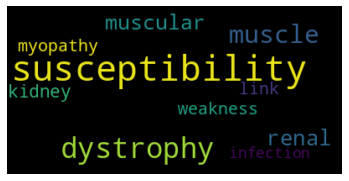

In [47]:
wordcloud_component_vocab(4,component_vocab_louvain)

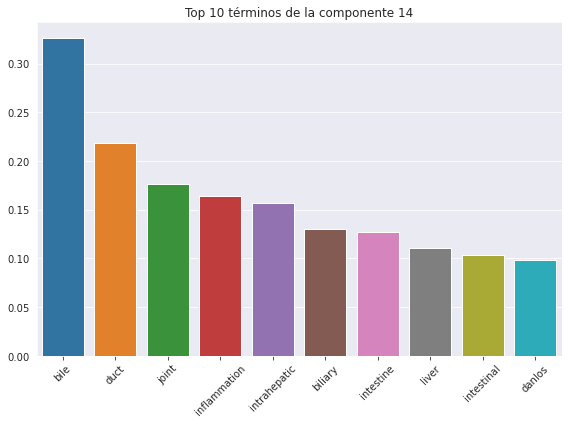

In [83]:
plot_component_vocab(14,component_vocab_infomap)

In [84]:
lsa_infomap_df = pd.DataFrame(lsa_infomap_data, index=X_infomap.index.values)
lsa_louvain_df = pd.DataFrame(lsa_louvain_data, index=X_louvain.index.values)

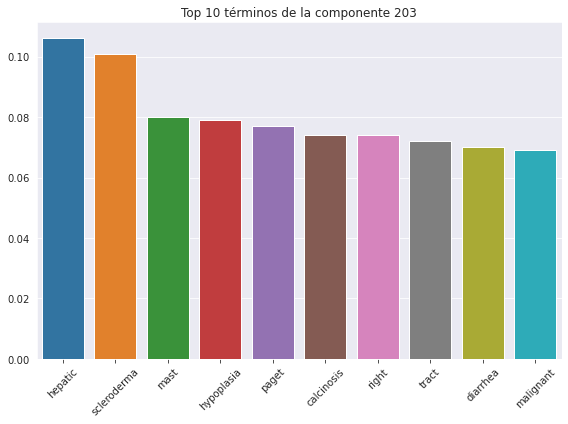

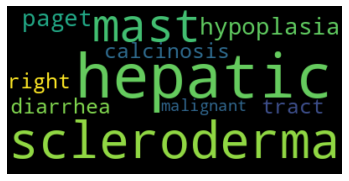

,node_index,comunidades_infomap,comunidades_louvain,node_id,node_name,disgenet_type,mondo_id,mondo_name,mondo_definition,umls_description,orphanet_definition,diseaseClassMSH,diseaseClassNameMSH,node_source
802,12904,110.0,25.0,60715_100252_60714,"tumoral calcinosis, hyperphosphatemic, familial",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,primekg
4174,22611,110.0,25.0,C0263628,Tumoral calcinosis,disease,18891.0,familial tumoral calcinosis,Tumoral calcinosis is a phosphocalcic metaboli...,An extremely rare benign condition characteriz...,Tumoral calcinosis is a phosphocalcic metaboli...,C18,Nutritional and Metabolic Diseases,disgenet
8585,28994,110.0,25.0,C1864861,"Tumoral Calcinosis, Normophosphatemic, Familial",disease,12502.0,normophosphatemic familial tumoral calcinosis,NaN,NaN,NaN,C16;C18;C05,"Congenital, Hereditary, and Neonatal Diseases ...",disgenet
12330,33842,110.0,25.0,C4693863,"TUMORAL CALCINOSIS, HYPERPHOSPHATEMIC, FAMILIA...",disease,60714.0,"tumoral calcinosis, hyperphosphatemic, familia...",NaN,NaN,NaN,NaN,NaN,disgenet
12331,33843,110.0,25.0,C4693864,"TUMORAL CALCINOSIS, HYPERPHOSPHATEMIC, FAMILIA...",disease,60715.0,"tumoral calcinosis, hyperphosphatemic, familia...",NaN,NaN,NaN,NaN,NaN,disgenet


In [108]:
random_cluster = np.random.choice(X_infomap.index.values,1)[0]
top_component = lsa_infomap_df.loc[random_cluster].idxmax()

plot_component_vocab(top_component,component_vocab_infomap)
wordcloud_component_vocab(top_component,component_vocab_infomap)

if top_component == 0:
    second_component = lsa_infomap_df.loc[random_cluster].sort_values(ascending=False).index[1]
    plot_component_vocab(top_component,component_vocab_infomap)
    wordcloud_component_vocab(top_component,component_vocab_infomap)

disease_attributes[disease_attributes.comunidades_infomap == random_cluster]

array(['ALK positive large B-cell lymphoma',
       'Anaplastic lymphoma kinase (ALK)-positive diffuse large B-cell lymphoma is a very rare variant of diffuse large B-cell lymphoma (DLBCL) mainly affecting middle-aged immunocompetent men and characterized by a consistent primary involvement of lymph nodes (mainly in the cervical and mediastinum lymph nodes) and with infrequent extra nodal involvement of the bone marrow and other extra-nodal sites (head and neck region, liver, spleen, and gastrointestinal tract). It has an aggressive disease course, and is associated with a poor prognosis.',
       'A usually aggressive large B-cell lymphoma characterized by the presence of monomorphic immunoblast-like neoplastic B-lymphocytes in a sinusoidal growth pattern. The neoplastic B-lymphocytes express the ALK kinase but they lack the 2;5 translocation.',
       'A very rare variant of diffuse large B-cell lymphoma (DLBCL) mainly affecting middle-aged immunocompetent men and characterized by a 

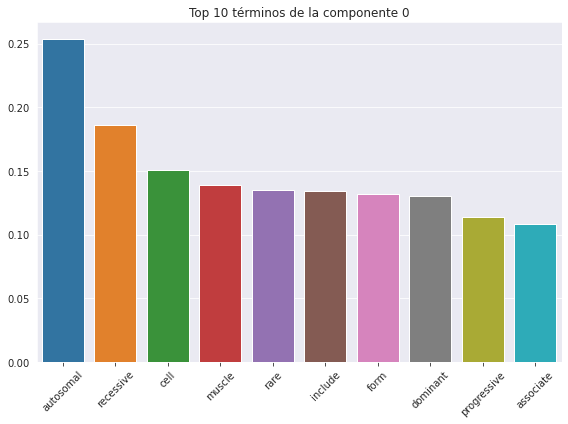

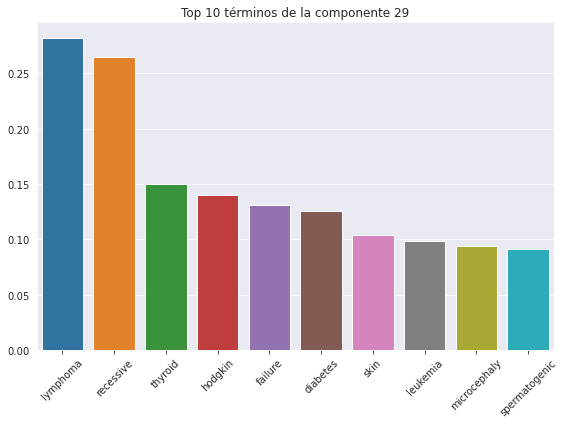

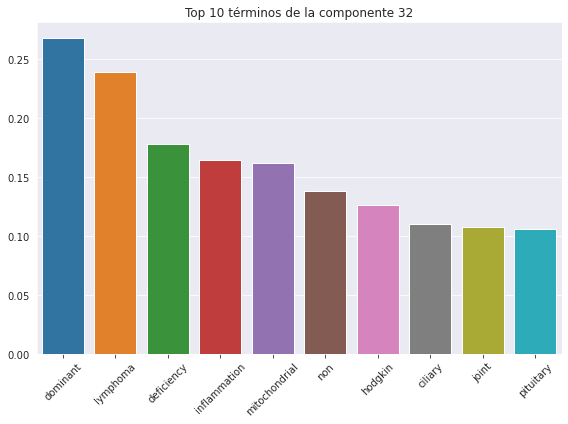

In [61]:
nodo = np.random.choice(range(lsa_data.shape[0]),1)[0]
vector_lsa = lsa_data[nodo]
top_10_components_idx = np.argsort(-vector_lsa)[0:10]
top_10_components_score = vector_lsa[top_10_components_idx]
node_data = disease_attributes.iloc[nodo][["node_name","mondo_definition","umls_description","orphanet_definition"]].values
display(node_data)
for component in top_10_components_idx[0:3]:
    plot_component_vocab(component, component_vocab)